# Data Preprocessing

In [1]:
import re
import pandas as pd
from contractions import fix
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger_eng')


from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag

sns.set()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\arbru\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\arbru\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\arbru\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\arbru\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


## X dataset

In [2]:
x_df = pd.read_csv('../data/annotated/dehatebert/classified_x_df_CNERG.csv')
x_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2042 entries, 0 to 2041
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          2042 non-null   int64  
 1   Username            2042 non-null   object 
 2   Country_Code        8 non-null      object 
 3   Possibly_Sensitive  2042 non-null   bool   
 4   Date_Created        2042 non-null   object 
 5   No_of_Likes         2042 non-null   int64  
 6   Source              1985 non-null   object 
 7   Full_Text           2042 non-null   object 
 8   label               2042 non-null   object 
 9   confidence          2042 non-null   float64
dtypes: bool(1), float64(1), int64(2), object(6)
memory usage: 145.7+ KB


In [3]:
x_df.describe()

,Unnamed: 0,No_of_Likes,confidence
count,2042.000000,2042.000000,2042.000000
mean,1020.500000,7.743879,0.864839
std,589.618945,78.573867,0.116052
min,0.000000,0.000000,0.500137
25%,510.250000,0.000000,0.806450
50%,1020.500000,0.000000,0.909009
75%,1530.750000,1.000000,0.957055
max,2041.000000,1530.000000,0.978073


In [4]:
x_df.isnull().sum()

Unnamed: 0               0
Username                 0
Country_Code          2034
Possibly_Sensitive       0
Date_Created             0
No_of_Likes              0
Source                  57
Full_Text                0
label                    0
confidence               0
dtype: int64

In [5]:
print(f"Duplicates: {x_df.duplicated().sum()}")

Duplicates: 0


In [6]:
x_df

,Unnamed: 0,Username,Country_Code,Possibly_Sensitive,Date_Created,No_of_Likes,Source,Full_Text,label,confidence
0,0,DevilHatman,NaN,False,2024-12-16 22:49:58+00:00,0,NaN,Once again @elonmusk and @X claim to be about ...,NON_HATE,0.938621
1,1,AmericanaMama_,NaN,False,2024-12-16 21:48:19+00:00,43,NaN,Leftists don't ban hate speech. \n\nThey ban s...,NON_HATE,0.670734
2,2,AnubisVRC,NaN,False,2024-12-16 21:32:25+00:00,0,NaN,To anyone on Vrchat o would say at this time o...,NON_HATE,0.949399
3,3,RaviManickavas1,NaN,False,2024-12-16 21:29:31+00:00,0,NaN,Saturday Morning's Earth Odyssey and NBC Comme...,NON_HATE,0.943067
4,4,usersnotreal,NaN,False,2024-12-16 21:23:28+00:00,0,NaN,Was gonna relapse but my bf gave a huge hate s...,NON_HATE,0.867823
...,...,...,...,...,...,...,...,...,...,...
2037,2037,JkittenYT,NaN,False,2025-03-18 22:27:36+00:00,0,X,Fuck you,NON_HATE,0.977394
2038,2038,phattFoxx_,NaN,False,2025-03-18 22:27:33+00:00,1,X,When I say fuck you all together just know I g...,NON_HATE,0.903720
2039,2039,satan_life,NaN,False,2025-03-18 22:27:31+00:00,0,X,"Fuck you, Elon. Bring back the Dropkick Murphy...",NON_HATE,0.799901
2040,2040,__marjestic,NaN,False,2025-03-18 22:27:26+00:00,0,X,Fuck you,NON_HATE,0.977394


In [7]:
def censor_words(text, banned_words):
    def censor_match(match):
        word = match.group(0)
        censored_word = re.sub(r'([aeiouAEIOU])', '*', word, count=1)
        return censored_word

    pattern = r"\b(" + "|".join(re.escape(word) for word in banned_words) + r")\b"
    return re.sub(pattern, censor_match, text, flags=re.IGNORECASE)


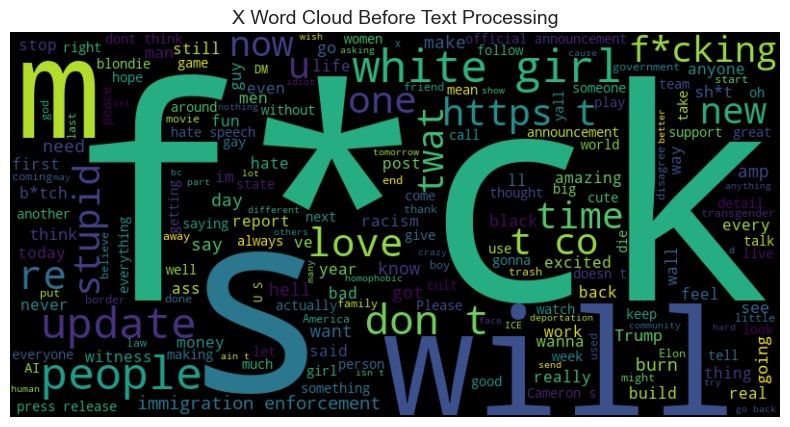

In [8]:
from wordcloud import WordCloud

text_data = " ".join(x_df["Full_Text"].astype(str))
banned_words = {"fuck", "fucking", "shit", "bitch", "faggot", "nigga"}

censored_text = censor_words(text_data, banned_words)

wordcloud = WordCloud(
    width=800, height=400,
    background_color="black",
    colormap="viridis",
    max_words=200,  
    regexp=r"\b[a-zA-Z*]+\b" 
).generate(censored_text)


plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("X Word Cloud Before Text Processing", fontsize=14)
plt.show()

In [9]:
def clean_text(text):
    """
    Function that removes @, special characters or hashtags.
    """
    text = text.lower()
    text = re.sub(r'@\w+', ' ', text)
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'[^a-z\s]', '', text)
    return text.strip()

In [10]:
from wordsegment import load, segment

load()

def fix_hashtags(text):
    words = text.split()
    processed_words = []
    
    for word in words:
        if word.startswith("#"):
            clean_word = word[1:]  
            
            if re.search(r'[A-Z]', clean_word):
                clean_word = re.sub(r'([a-z])([A-Z])', r'\1 \2', clean_word)
            else:
                clean_word = " ".join(segment(clean_word))
            
            processed_words.append(clean_word)
        else:
            processed_words.append(word)

    return " ".join(processed_words)

In [11]:
x_df["cleaned_text"] = x_df["Full_Text"].apply(fix)
x_df.head()

,Unnamed: 0,Username,Country_Code,Possibly_Sensitive,Date_Created,No_of_Likes,Source,Full_Text,label,confidence,cleaned_text
0,0,DevilHatman,NaN,False,2024-12-16 22:49:58+00:00,0,NaN,Once again @elonmusk and @X claim to be about ...,NON_HATE,0.938621,Once again @elonmusk and @X claim to be about ...
1,1,AmericanaMama_,NaN,False,2024-12-16 21:48:19+00:00,43,NaN,Leftists don't ban hate speech. \n\nThey ban s...,NON_HATE,0.670734,Leftists do not ban hate speech. \n\nThey ban ...
2,2,AnubisVRC,NaN,False,2024-12-16 21:32:25+00:00,0,NaN,To anyone on Vrchat o would say at this time o...,NON_HATE,0.949399,To anyone on Vrchat o would say at this time o...
3,3,RaviManickavas1,NaN,False,2024-12-16 21:29:31+00:00,0,NaN,Saturday Morning's Earth Odyssey and NBC Comme...,NON_HATE,0.943067,Saturday Morning's Earth Odyssey and NBC Comme...
4,4,usersnotreal,NaN,False,2024-12-16 21:23:28+00:00,0,NaN,Was gonna relapse but my bf gave a huge hate s...,NON_HATE,0.867823,Was going to relapse but my bf gave a huge hat...


In [12]:
x_df["cleaned_text"] = x_df["cleaned_text"].astype(str).apply(clean_text)
x_df.tail()

,Unnamed: 0,Username,Country_Code,Possibly_Sensitive,Date_Created,No_of_Likes,Source,Full_Text,label,confidence,cleaned_text
2037,2037,JkittenYT,NaN,False,2025-03-18 22:27:36+00:00,0,X,Fuck you,NON_HATE,0.977394,fuck you
2038,2038,phattFoxx_,NaN,False,2025-03-18 22:27:33+00:00,1,X,When I say fuck you all together just know I g...,NON_HATE,0.903720,when i say fuck you all together just know i g...
2039,2039,satan_life,NaN,False,2025-03-18 22:27:31+00:00,0,X,"Fuck you, Elon. Bring back the Dropkick Murphy...",NON_HATE,0.799901,fuck you elon bring back the dropkick murphys ...
2040,2040,__marjestic,NaN,False,2025-03-18 22:27:26+00:00,0,X,Fuck you,NON_HATE,0.977394,fuck you
2041,2041,4lilce,NaN,False,2025-03-18 22:27:07+00:00,8,X,being the realest straight hurt when u only me...,NON_HATE,0.920300,being the realest straight hurt when you only ...


In [13]:
x_df["cleaned_text"] = x_df["cleaned_text"].astype(str).apply(fix_hashtags)
x_df

,Unnamed: 0,Username,Country_Code,Possibly_Sensitive,Date_Created,No_of_Likes,Source,Full_Text,label,confidence,cleaned_text
0,0,DevilHatman,NaN,False,2024-12-16 22:49:58+00:00,0,NaN,Once again @elonmusk and @X claim to be about ...,NON_HATE,0.938621,once again and claim to be about free speech b...
1,1,AmericanaMama_,NaN,False,2024-12-16 21:48:19+00:00,43,NaN,Leftists don't ban hate speech. \n\nThey ban s...,NON_HATE,0.670734,leftists do not ban hate speech they ban speec...
2,2,AnubisVRC,NaN,False,2024-12-16 21:32:25+00:00,0,NaN,To anyone on Vrchat o would say at this time o...,NON_HATE,0.949399,to anyone on vrchat o would say at this time o...
3,3,RaviManickavas1,NaN,False,2024-12-16 21:29:31+00:00,0,NaN,Saturday Morning's Earth Odyssey and NBC Comme...,NON_HATE,0.943067,saturday mornings earth odyssey and nbc commer...
4,4,usersnotreal,NaN,False,2024-12-16 21:23:28+00:00,0,NaN,Was gonna relapse but my bf gave a huge hate s...,NON_HATE,0.867823,was going to relapse but my bf gave a huge hat...
...,...,...,...,...,...,...,...,...,...,...,...
2037,2037,JkittenYT,NaN,False,2025-03-18 22:27:36+00:00,0,X,Fuck you,NON_HATE,0.977394,fuck you
2038,2038,phattFoxx_,NaN,False,2025-03-18 22:27:33+00:00,1,X,When I say fuck you all together just know I g...,NON_HATE,0.903720,when i say fuck you all together just know i g...
2039,2039,satan_life,NaN,False,2025-03-18 22:27:31+00:00,0,X,"Fuck you, Elon. Bring back the Dropkick Murphy...",NON_HATE,0.799901,fuck you elon bring back the dropkick murphys ...
2040,2040,__marjestic,NaN,False,2025-03-18 22:27:26+00:00,0,X,Fuck you,NON_HATE,0.977394,fuck you


In [14]:
x_df["tokens"] = x_df["cleaned_text"].apply(word_tokenize)
print(x_df[["cleaned_text", "tokens"]].head())

                                        cleaned_text  \
0  once again and claim to be about free speech b...   
1  leftists do not ban hate speech they ban speec...   
2  to anyone on vrchat o would say at this time o...   
3  saturday mornings earth odyssey and nbc commer...   
4  was going to relapse but my bf gave a huge hat...   

                                              tokens  
0  [once, again, and, claim, to, be, about, free,...  
1  [leftists, do, not, ban, hate, speech, they, b...  
2  [to, anyone, on, vrchat, o, would, say, at, th...  
3  [saturday, mornings, earth, odyssey, and, nbc,...  
4  [was, going, to, relapse, but, my, bf, gave, a...  


In [15]:
stop_words = set(stopwords.words('english'))
stop_words.discard("not")
x_df["tokens"] = x_df["tokens"].apply(lambda words: [w for w in words if w not in stop_words])
x_df["tokens"]

0       [claim, free, speech, reality, far, different,...
1       [leftists, not, ban, hate, speech, ban, speech...
2       [anyone, vrchat, would, say, time, year, put, ...
3       [saturday, mornings, earth, odyssey, nbc, comm...
4       [going, relapse, bf, gave, huge, hate, speech,...
                              ...                        
2037                                               [fuck]
2038            [say, fuck, together, know, gave, chance]
2039    [fuck, elon, bring, back, dropkick, murphys, f...
2040                                               [fuck]
2041    [realest, straight, hurt, mean, well, amp, peo...
Name: tokens, Length: 2042, dtype: object

In [16]:
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def lemmatize_with_pos(words):
    tagged = pos_tag(words)
    return [lemmatizer.lemmatize(w, get_wordnet_pos(tag)) for w, tag in tagged]


In [17]:
def remove_consecutive_duplicates(tokens):
    result = []
    prev = None
    for token in tokens:
        if token != prev:
            result.append(token)
        prev = token
    return result


In [18]:
x_df["tokens"] = x_df["tokens"].apply(lemmatize_with_pos)
x_df["tokens"] = x_df["tokens"].apply(remove_consecutive_duplicates)
x_df["processed_text"] = x_df["tokens"].apply(lambda words: ' '.join(words))
x_df["processed_text"]


0       claim free speech reality far different not cr...
1             leftist not ban hate speech ban speech hate
2       anyone vrchat would say time year put radical ...
3       saturday morning earth odyssey nbc commercials...
4       go relapse bf give huge hate speech dm would i...
                              ...                        
2037                                                 fuck
2038                   say fuck together know give chance
2039    fuck elon bring back dropkick murphy facist pi...
2040                                                 fuck
2041    realest straight hurt mean well amp people sti...
Name: processed_text, Length: 2042, dtype: object

In [19]:
x_df.drop_duplicates(subset="processed_text", inplace=True)

In [20]:
x_df[x_df["processed_text"].apply(lambda words: "fuck fuck" in words)]

,Unnamed: 0,Username,Country_Code,Possibly_Sensitive,Date_Created,No_of_Likes,Source,Full_Text,label,confidence,cleaned_text,tokens,processed_text
1670,1670,Vthenumber23,NaN,False,2025-03-18 21:44:59+00:00,0,X,Fuxk everything fuxk you fuck you told fuck hu...,HATE,0.866854,fuxk everything fuxk you fuck you told fuck hu...,"[fuxk, everything, fuxk, fuck, told, fuck, hum...",fuxk everything fuxk fuck told fuck human fuck...
1994,1994,CLOUD9114X,NaN,False,2025-03-18 22:37:55+00:00,0,X,"fuck you, fucken NAZIS",NON_HATE,0.759639,fuck you fucken nazis,"[fuck, fucken, nazi]",fuck fucken nazi


In [21]:
new_x = x_df[["processed_text", "label"]]

In [22]:
new_x.to_csv("../data/processed/processed_x_dataset.csv", index=False)

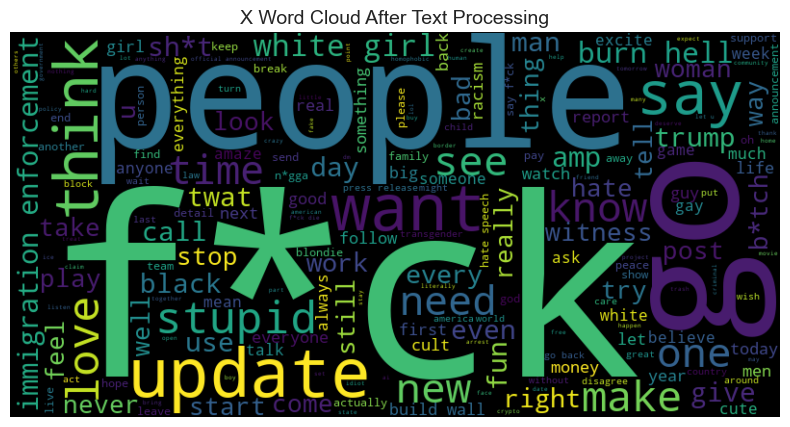

In [23]:
from wordcloud import WordCloud

text_data = " ".join(new_x["processed_text"].astype(str))
banned_words = {"fuck", "fucking", "shit", "bitch", "faggot", "nigga"}
censored_text = censor_words(text_data, banned_words)

wordcloud = WordCloud(
    width=800, height=400,
    background_color="black",
    colormap="viridis",
    max_words=200,
    regexp=r"\b[a-zA-Z*]+\b"   
).generate(censored_text)


plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("X Word Cloud After Text Processing", fontsize=14)
plt.show()


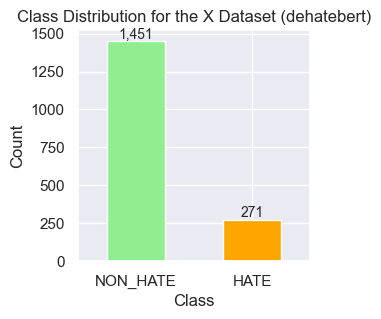

In [24]:
class_count = x_df['label'].value_counts()
plt.figure(figsize=(3,3))
bars = class_count.plot(kind='bar', color=['lightgreen','orange','red'])

for bar in bars.patches:
    plt.text(bar.get_x() + bar.get_width() / 2, 
             bar.get_height(), 
             f"{bar.get_height():,}",
             ha="center", va="bottom", fontsize=10)
    
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Class Distribution for the X Dataset (dehatebert)")
plt.xticks(rotation=0)
plt.show()

## Reddit dataset

In [25]:
reddit_df = pd.read_csv("../data/annotated/dehatebert/classified_reddit_df_CNERG.csv")
reddit_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46638 entries, 0 to 46637
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      46638 non-null  int64  
 1   title           46638 non-null  object 
 2   body            19125 non-null  object 
 3   author          46638 non-null  object 
 4   comment         46638 non-null  object 
 5   comment_author  38974 non-null  object 
 6   score           46638 non-null  int64  
 7   upvote_ratio    46638 non-null  float64
 8   created_utc     46638 non-null  object 
 9   subreddit       46638 non-null  object 
 10  label           46638 non-null  object 
 11  confidence      46638 non-null  float64
dtypes: float64(2), int64(2), object(8)
memory usage: 4.3+ MB


In [26]:
reddit_df.describe()

,Unnamed: 0,score,upvote_ratio,confidence
count,46638.000000,46638.000000,46638.000000,46638.000000
mean,23318.500000,12617.964149,0.871977,0.911223
std,13463.375264,14429.522386,0.085995,0.094972
min,0.000000,0.000000,0.450000,0.500335
25%,11659.250000,1389.000000,0.820000,0.893501
50%,23318.500000,6913.000000,0.890000,0.952038
75%,34977.750000,15098.000000,0.940000,0.971738
max,46637.000000,50156.000000,1.000000,0.979011


In [27]:
reddit_df.isnull().sum()

Unnamed: 0            0
title                 0
body              27513
author                0
comment               0
comment_author     7664
score                 0
upvote_ratio          0
created_utc           0
subreddit             0
label                 0
confidence            0
dtype: int64

In [28]:
print(f"Duplicates: {reddit_df.duplicated().sum()}")

Duplicates: 0


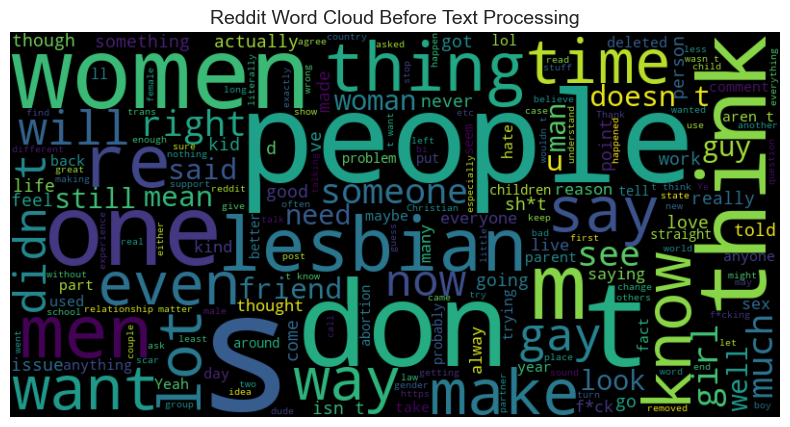

In [29]:
from wordcloud import WordCloud

text_data = " ".join(reddit_df["comment"].astype(str))
banned_words = {"fuck", "fucking", "shit", "bitch", "faggot", "nigga"}

censored_text = censor_words(text_data, banned_words)

wordcloud = WordCloud(
    width=800, height=400,
    background_color="black",
    colormap="viridis",
    max_words=200,  
    regexp=r"\b[a-zA-Z*]+\b" 
).generate(censored_text)


plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Reddit Word Cloud Before Text Processing", fontsize=14)
plt.show()

In [30]:
reddit_df["cleaned_text"] = reddit_df["comment"].apply(fix)

In [31]:
reddit_df["cleaned_text"] = reddit_df["cleaned_text"].astype(str).apply(clean_text)

In [32]:
reddit_df["cleaned_text"] = reddit_df["cleaned_text"].astype(str).apply(fix_hashtags)
reddit_df

,Unnamed: 0,title,body,author,comment,comment_author,score,upvote_ratio,created_utc,subreddit,label,confidence,cleaned_text
0,0,"Patriarchy, Marginalized Genders, Queer Femini...",Discussion + Vent + Stream of Consciousness po...,Oddly-Ordinary,Sounds like you should come on down and join u...,Merladylu,4,0.75,2024-10-30 17:25:36+0000,gender,NON_HATE,0.911610,sounds like you should come on down and join u...
1,1,Lesbian gender?,"For context I'm a member of a system, as a who...",Beyond_The_Stars815,it makes sense to me? it's kinda confusing but...,Toricon,6,1.00,2022-10-17 22:01:31+0000,gender,NON_HATE,0.947165,it makes sense to me it is kind of confusing b...
2,2,Lesbian gender?,"For context I'm a member of a system, as a who...",Beyond_The_Stars815,[removed],NaN,6,1.00,2022-10-17 22:01:31+0000,gender,NON_HATE,0.975493,removed
3,3,Lesbian gender?,"For context I'm a member of a system, as a who...",Beyond_The_Stars815,I'm still a bit confused as to what you're des...,shadowxthevamp,6,1.00,2022-10-17 22:01:31+0000,gender,NON_HATE,0.908459,i am still a bit confused as to what you are d...
4,4,Lesbian gender?,"For context I'm a member of a system, as a who...",Beyond_The_Stars815,"Lesbian is a sexual orientation, not a gender....",GiveMeUrBankingInfo,6,1.00,2022-10-17 22:01:31+0000,gender,NON_HATE,0.861022,lesbian is a sexual orientation not a gender a...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
46633,46633,The sheriff fired her because she’s a lesbian ...,NaN,Majnum,He is the only thing that makes Kentucky relev...,SpideyTingle,34075,0.85,2020-11-04 13:01:07+0000,TwoXChromosomes,NON_HATE,0.977293,he is the only thing that makes kentucky relevant
46634,46634,The sheriff fired her because she’s a lesbian ...,NaN,Majnum,What would that look like though? As much as I...,maybeelean,34075,0.85,2020-11-04 13:01:07+0000,TwoXChromosomes,NON_HATE,0.954576,what would that look like though as much as i ...
46635,46635,The sheriff fired her because she’s a lesbian ...,NaN,Majnum,If the only thing Mitch McConnell could bring ...,ablake0406,34075,0.85,2020-11-04 13:01:07+0000,TwoXChromosomes,NON_HATE,0.930404,if the only thing mitch mcconnell could bring ...
46636,46636,The sheriff fired her because she’s a lesbian ...,NaN,Majnum,You already have states. Just make them indepe...,MegaBaumTV,34075,0.85,2020-11-04 13:01:07+0000,TwoXChromosomes,NON_HATE,0.917807,you already have states just make them indepen...


In [33]:
reddit_df["tokens"] = reddit_df["cleaned_text"].apply(word_tokenize)
print(reddit_df[["cleaned_text", "tokens"]].head())

                                        cleaned_text  \
0  sounds like you should come on down and join u...   
1  it makes sense to me it is kind of confusing b...   
2                                            removed   
3  i am still a bit confused as to what you are d...   
4  lesbian is a sexual orientation not a gender a...   

                                              tokens  
0  [sounds, like, you, should, come, on, down, an...  
1  [it, makes, sense, to, me, it, is, kind, of, c...  
2                                          [removed]  
3  [i, am, still, a, bit, confused, as, to, what,...  
4  [lesbian, is, a, sexual, orientation, not, a, ...  


In [34]:
stop_words = set(stopwords.words('english'))
stop_words.discard("not")
reddit_df["tokens"] = reddit_df["tokens"].apply(lambda words: [w for w in words if w not in stop_words])
reddit_df["tokens"]

0        [sounds, like, come, join, us, pansexual, part...
1        [makes, sense, kind, confusing, gender, whole,...
2                                                [removed]
3        [still, bit, confused, describing, lesbian, ge...
4        [lesbian, sexual, orientation, not, gender, le...
                               ...                        
46633                   [thing, makes, kentucky, relevant]
46634    [would, look, like, though, much, agree, two, ...
46635    [thing, mitch, mcconnell, could, bring, misery...
46636                 [already, states, make, independent]
46637                                            [removed]
Name: tokens, Length: 46638, dtype: object

In [35]:
lemmatizer = WordNetLemmatizer()

reddit_df["tokens"] = reddit_df["tokens"].apply(lemmatize_with_pos)
reddit_df["tokens"] = reddit_df["tokens"].apply(remove_consecutive_duplicates)
reddit_df["processed_text"] = reddit_df["tokens"].apply(lambda words: ' '.join(words))
reddit_df["processed_text"].tail(30)

46608                                     remember grammar
46609                                         fuck awesome
46610      cool job right help change law enforcement well
46611                                              sheriff
46612                                woman suzanne sommers
46613                             happy read story victory
46614                                                     
46615    add number felt little bit unclear primary for...
46616    yes local election voter huge impact really sh...
46617                                             remember
46618    sadly not enough karmic power moscow mitch con...
46619                                                smort
46620               name remind need buy hail sagan tshirt
46621              another law enforcement lesbian working
46622                          literal justice boner right
46623               thanks unclear need happy news morning
46624                                                 na

In [36]:
to_be_removed = ["remove","delete"]
reddit_df = reddit_df[~reddit_df["processed_text"].isin(to_be_removed)]
reddit_df

,Unnamed: 0,title,body,author,comment,comment_author,score,upvote_ratio,created_utc,subreddit,label,confidence,cleaned_text,tokens,processed_text
0,0,"Patriarchy, Marginalized Genders, Queer Femini...",Discussion + Vent + Stream of Consciousness po...,Oddly-Ordinary,Sounds like you should come on down and join u...,Merladylu,4,0.75,2024-10-30 17:25:36+0000,gender,NON_HATE,0.911610,sounds like you should come on down and join u...,"[sound, like, come, join, u, pansexual, party,...",sound like come join u pansexual party want
1,1,Lesbian gender?,"For context I'm a member of a system, as a who...",Beyond_The_Stars815,it makes sense to me? it's kinda confusing but...,Toricon,6,1.00,2022-10-17 22:01:31+0000,gender,NON_HATE,0.947165,it makes sense to me it is kind of confusing b...,"[make, sense, kind, confuse, gender, whole, co...",make sense kind confuse gender whole confuse c...
3,3,Lesbian gender?,"For context I'm a member of a system, as a who...",Beyond_The_Stars815,I'm still a bit confused as to what you're des...,shadowxthevamp,6,1.00,2022-10-17 22:01:31+0000,gender,NON_HATE,0.908459,i am still a bit confused as to what you are d...,"[still, bit, confused, describe, lesbian, gend...",still bit confused describe lesbian gender say...
4,4,Lesbian gender?,"For context I'm a member of a system, as a who...",Beyond_The_Stars815,"Lesbian is a sexual orientation, not a gender....",GiveMeUrBankingInfo,6,1.00,2022-10-17 22:01:31+0000,gender,NON_HATE,0.861022,lesbian is a sexual orientation not a gender a...,"[lesbian, sexual, orientation, not, gender, le...",lesbian sexual orientation not gender lesbian ...
5,5,Lesbian gender?,"For context I'm a member of a system, as a who...",Beyond_The_Stars815,Is sexual orientation and gender the same thing?,Sweaty-Tower-7709,6,1.00,2022-10-17 22:01:31+0000,gender,NON_HATE,0.975464,is sexual orientation and gender the same thing,"[sexual, orientation, gender, thing]",sexual orientation gender thing
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46632,46632,The sheriff fired her because she’s a lesbian ...,NaN,Majnum,european here. why just not separate the US in...,MegaBaumTV,34075,0.85,2020-11-04 13:01:07+0000,TwoXChromosomes,NON_HATE,0.947480,european here why just not separate the us in ...,"[european, not, separate, u, many, small, inde...",european not separate u many small independent...
46633,46633,The sheriff fired her because she’s a lesbian ...,NaN,Majnum,He is the only thing that makes Kentucky relev...,SpideyTingle,34075,0.85,2020-11-04 13:01:07+0000,TwoXChromosomes,NON_HATE,0.977293,he is the only thing that makes kentucky relevant,"[thing, make, kentucky, relevant]",thing make kentucky relevant
46634,46634,The sheriff fired her because she’s a lesbian ...,NaN,Majnum,What would that look like though? As much as I...,maybeelean,34075,0.85,2020-11-04 13:01:07+0000,TwoXChromosomes,NON_HATE,0.954576,what would that look like though as much as i ...,"[would, look, like, though, much, agree, two, ...",would look like though much agree two differen...
46635,46635,The sheriff fired her because she’s a lesbian ...,NaN,Majnum,If the only thing Mitch McConnell could bring ...,ablake0406,34075,0.85,2020-11-04 13:01:07+0000,TwoXChromosomes,NON_HATE,0.930404,if the only thing mitch mcconnell could bring ...,"[thing, mitch, mcconnell, could, bring, misery...",thing mitch mcconnell could bring misery kentu...


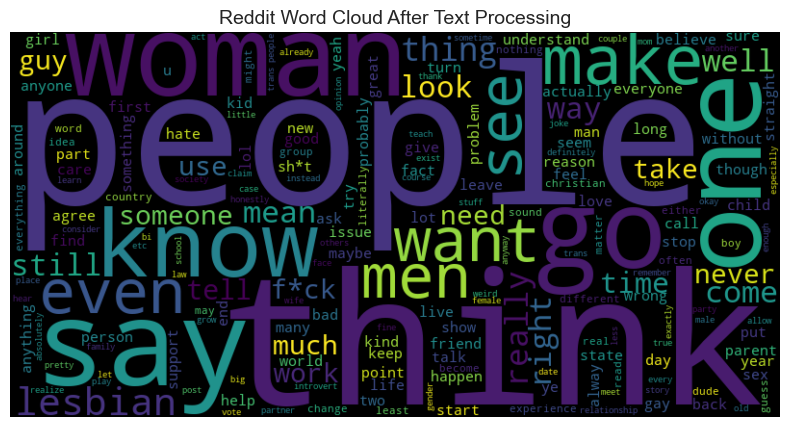

In [37]:
from wordcloud import WordCloud

text_data = " ".join(reddit_df["processed_text"].astype(str))
banned_words = {"fuck", "fucking", "shit", "bitch", "faggot", "nigga"}

censored_text = censor_words(text_data, banned_words)

wordcloud = WordCloud(
    width=800, height=400,
    background_color="black",
    colormap="viridis",
    max_words=200,  
    regexp=r"\b[a-zA-Z*]+\b" 
).generate(censored_text)


plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Reddit Word Cloud After Text Processing", fontsize=14)
plt.show()

In [38]:
reddit_class = reddit_df['label'].value_counts()

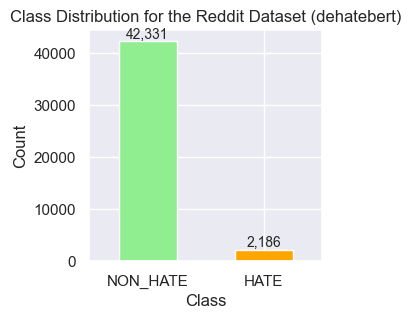

In [39]:
plt.figure(figsize=(3,3))
reddit_bar = reddit_class.plot(kind='bar', color=['lightgreen','orange','red'])
for bar in reddit_bar.patches:
    plt.text(bar.get_x() + bar.get_width() / 2, 
             bar.get_height(), 
             f"{bar.get_height():,}",
             ha="center", va="bottom", fontsize=10)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title("Class Distribution for the Reddit Dataset (dehatebert)")
plt.xticks(rotation=0)
plt.show()

In [40]:
reddit_df[['processed_text', 'label']].to_csv('../data/processed/processed_reddit_dataset.csv')

## Kaggle dataset

In [42]:
k_df = pd.read_csv('../data/HateSpeechDatasetBalanced.csv')


In [43]:
print(len(k_df))
k_df.drop_duplicates(subset='Content', inplace=True)
print(f"Length w/o duplicates {len(k_df)}")


726119
Length w/o duplicates 700067


In [44]:
k_df["cleaned_text"] = k_df["Content"].apply(fix)
k_df["cleaned_text"] = k_df["cleaned_text"].astype(str).apply(clean_text)
k_df.tail()

,Content,Label,cleaned_text
726114,i mute this telecasting and played kanye west ...,1,i mute this telecasting and played kanye west ...
726115,but hell yeah he s not a bachelor but looooooo...,1,but hell yeah he s not a bachelor but looooooo...
726116,great video musician but s not my musician lol...,1,great video musician but s not my musician lol...
726117,not great pop video yeah he s not a pedophile ...,1,not great pop video yeah he s not a pedophile ...
726118,great video yeah he s non a paedophile lolllll...,1,great video yeah he s non a paedophile lolllll...


In [45]:
k_df["cleaned_text"] = k_df["Content"].astype(str).apply(fix_hashtags)

In [46]:
k_df["tokens"] = k_df["cleaned_text"].apply(word_tokenize)
print(k_df[["cleaned_text", "tokens"]].head())

                                        cleaned_text  \
0  denial of normal the con be asked to comment o...   
1  just by being able to tweet this insufferable ...   
2  that is retarded you too cute to be single tha...   
3  thought of a real badass mongol style declarat...   
4                                afro american basho   

                                              tokens  
0  [denial, of, normal, the, con, be, asked, to, ...  
1  [just, by, being, able, to, tweet, this, insuf...  
2  [that, is, retarded, you, too, cute, to, be, s...  
3  [thought, of, a, real, badass, mongol, style, ...  
4                            [afro, american, basho]  


In [47]:
stop_words = set(stopwords.words('english'))
stop_words.discard("not")
k_df["tokens"] = k_df["tokens"].apply(lambda words: [w for w in words if w not in stop_words])

In [48]:
lemmatizer = WordNetLemmatizer()

k_df["tokens"] = k_df["tokens"].apply(lemmatize_with_pos)
k_df["tokens"] = k_df["tokens"].apply(remove_consecutive_duplicates)
k_df["processed_text"] = k_df["tokens"].apply(lambda words: ' '.join(words))

In [49]:
k_df.rename(columns={'Label':'label'}, inplace=True)

In [50]:
k_df

,Content,label,cleaned_text,tokens,processed_text
0,denial of normal the con be asked to comment o...,1,denial of normal the con be asked to comment o...,"[denial, normal, con, ask, comment, tragedy, e...",denial normal con ask comment tragedy emotiona...
1,just by being able to tweet this insufferable ...,1,just by being able to tweet this insufferable ...,"[able, tweet, insufferable, bullshit, prove, t...",able tweet insufferable bullshit prove trump n...
2,that is retarded you too cute to be single tha...,1,that is retarded you too cute to be single tha...,"[retard, cute, single, life]",retard cute single life
3,thought of a real badass mongol style declarat...,1,thought of a real badass mongol style declarat...,"[think, real, badass, mongol, style, declarati...",think real badass mongol style declaration war...
4,afro american basho,1,afro american basho,"[afro, american, basho]",afro american basho
...,...,...,...,...,...
726114,i mute this telecasting and played kanye west ...,1,i mute this telecasting and played kanye west ...,"[mute, telecast, play, kanye, west, clique, kn...",mute telecast play kanye west clique know damn...
726115,but hell yeah he s not a bachelor but looooooo...,1,but hell yeah he s not a bachelor but looooooo...,"[hell, yeah, not, bachelor, looooooooooooooooo...",hell yeah not bachelor loooooooooooooooooooooo...
726116,great video musician but s not my musician lol...,1,great video musician but s not my musician lol...,"[great, video, musician, not, musician, lollll...",great video musician not musician lollllllllll...
726117,not great pop video yeah he s not a pedophile ...,1,not great pop video yeah he s not a pedophile ...,"[not, great, pop, video, yeah, not, pedophile,...",not great pop video yeah not pedophile yeah lo...


In [51]:
k_df[["processed_text", "label"]].to_csv("../data/processed/processed_kaggle_dataset.csv", index=False)